# Drive Integration Automatic Saving

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run this js code in the colab console terminal to keep the session alive, while training the model for long hours
'''
//credit - https://huggingface.co/blog/fine-tune-wav2vec2-english (Patrick von Platen)

// run this on your Chrome / Browser Console (where Colab is present)

function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}

var colab = setInterval(ConnectButton,60000);

// uncomment the below line and use it for clearing
//clearInterval(colab)

'''

In [ ]:
import shutil
import os
import datetime

model_name ="finbert_fingptSentiment_labels_3"
base_colab_folder="colab_downloaded"


drive_model_root = f"/content/drive/MyDrive/{base_colab_folder}/{model_name}"
local_model_root = f"/content/{model_name}"

# Create target Drive directory
os.makedirs(drive_model_root, exist_ok=True)
os.makedirs(local_model_root, exist_ok=True)

# Create symbolic link in Colab that points to Drive
if os.path.islink(local_model_root) or os.path.isdir(local_model_root):
    shutil.rmtree(local_model_root)
os.symlink(drive_model_root, local_model_root)

# Subdirectories
tensorboard_log_path = os.path.join(local_model_root, "logs")
os.makedirs(tensorboard_log_path, exist_ok=True)


print(f"Tensorboard log path: {tensorboard_log_path}")

Tensorboard log path: /content/finbert_fingptSentiment_labels_7/logs


# Dataset Handling

In [ ]:
from huggingface_hub import login
login(token="hf_XXXXXXXX") # Hugging face token to access the datasets

In [ ]:
import pandas as pd
df = pd.read_parquet("hf://datasets/FinGPT/fingpt-sentiment-train/data/train-00000-of-00001-dabab110260ac909.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76772 entries, 0 to 76771
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input        76772 non-null  object
 1   output       76772 non-null  object
 2   instruction  76772 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [ ]:
# only include input and output column
df = df[["input", "output"]]
df

,input,output
0,"Teollisuuden Voima Oyj , the Finnish utility k...",neutral
1,Sanofi poaches AstraZeneca scientist as new re...,neutral
2,Starbucks says the workers violated safety pol...,moderately negative
3,$brcm raises revenue forecast,positive
4,Google parent Alphabet Inc. reported revenue a...,moderately negative
...,...,...
76767,"BP, Statoil, to Withdraw Staff From Algeria Fo...",negative
76768,NEW YORK — A fire broke out late Wednesday at ...,mildly negative
76769,Operating profit margin increased from 11.2 % ...,positive
76770,$vxx adding to position here !,positive


In [ ]:
df = df[
      df['input'].notna() &
      df['output'].notna()
    ]
df.reset_index()
df

,input,output
0,"Teollisuuden Voima Oyj , the Finnish utility k...",neutral
1,Sanofi poaches AstraZeneca scientist as new re...,neutral
2,Starbucks says the workers violated safety pol...,moderately negative
3,$brcm raises revenue forecast,positive
4,Google parent Alphabet Inc. reported revenue a...,moderately negative
...,...,...
76767,"BP, Statoil, to Withdraw Staff From Algeria Fo...",negative
76768,NEW YORK — A fire broke out late Wednesday at ...,mildly negative
76769,Operating profit margin increased from 11.2 % ...,positive
76770,$vxx adding to position here !,positive


In [ ]:
df["output"].value_counts(normalize=True)

,proportion
output,
neutral,0.380542
positive,0.281196
negative,0.153038
moderately positive,0.080277
moderately negative,0.038712
mildly positive,0.033189
mildly negative,0.027458
strong negative,0.002840
strong positive,0.002748


In [ ]:
# only include the rows that have labels
only_include_labels = ['neutral','positive','negative']
df = df[df["output"].isin(only_include_labels)]
df

,input,output
0,"Teollisuuden Voima Oyj , the Finnish utility k...",neutral
1,Sanofi poaches AstraZeneca scientist as new re...,neutral
3,$brcm raises revenue forecast,positive
5,The Finnish company Stockmann has signed the c...,neutral
6,"Bernie Madoff, the former Wall Street investme...",neutral
...,...,...
76765,The investment will be worth approximately EUR...,neutral
76766,"Stop asking ""how are you?"" Harvard researchers...",neutral
76767,"BP, Statoil, to Withdraw Staff From Algeria Fo...",negative
76769,Operating profit margin increased from 11.2 % ...,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62552 entries, 0 to 76770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   62552 non-null  object
 1   output  62552 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


## Data Pre-processing

### Data Cleaning

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
import nltk

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # remove URLs
    text = re.sub(r'<.*?>', '', text)                    # remove HTML tags
    text = re.sub(r'@\w+', '', text)                     # remove mentions
    text = re.sub(r'#\w+', '', text)                     # remove hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)           # remove punctuation

    words = text.lower().strip().split()
    words = [word for word in words if word not in stop_words]  # remove stopwords
    return ' '.join(words)

df['input'] = df['input'].apply(clean_text)

/tmp/ipython-input-1814391730.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['input'] = df['input'].apply(clean_text)


In [ ]:
!pip install wordcloud

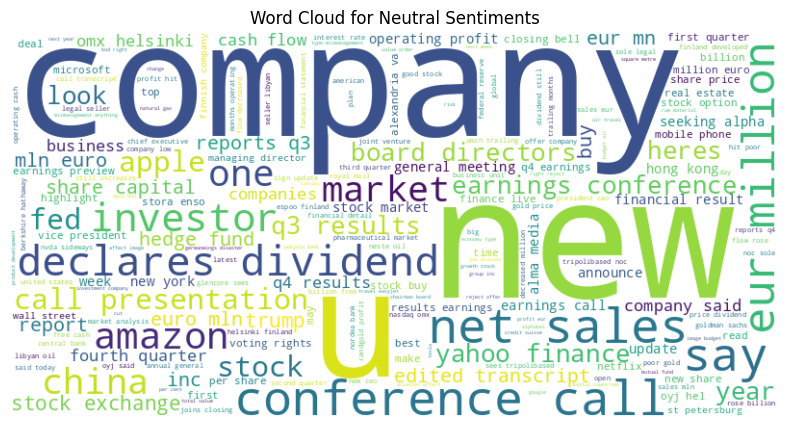

In [ ]:
from wordcloud import WordCloud

label_filter = "neutral"

# Combine all text entries into a single string
neutral_texts = df[df['output'] == label_filter]['input'].dropna()
text_combined = ' '.join(neutral_texts)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Neutral Sentiments")
plt.show()

### EDA

In [ ]:
# get words length distribution
df["words_length"] = df["input"].apply(lambda x: len(x.split()))
df

/tmp/ipython-input-194111311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["words_length"] = df["input"].apply(lambda x: len(x.split()))


,input,output,words_length
0,teollisuuden voima oyj finnish utility known t...,neutral,27
1,sanofi poaches astrazeneca scientist new resea...,neutral,7
3,brcm raises revenue forecast,positive,4
5,finnish company stockmann signed contract comp...,neutral,7
6,bernie madoff former wall street investment ad...,neutral,12
...,...,...,...
76765,investment worth approximately eur 100mn,neutral,5
76766,stop asking harvard researchers say successful...,neutral,11
76767,bp statoil withdraw staff algeria following ro...,negative,8
76769,operating profit margin increased 112 117,positive,6


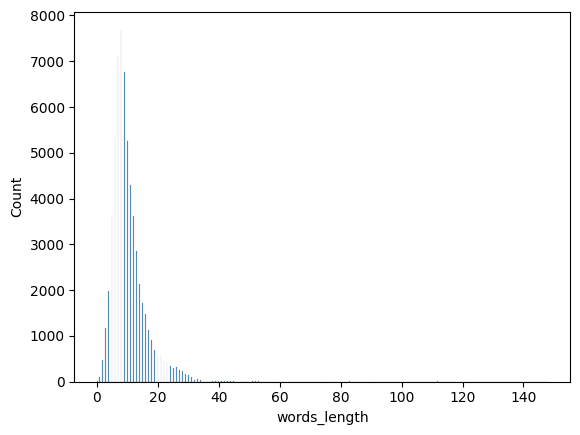

In [ ]:
# visuaize th words_length
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["words_length"])
plt.show()

### label mapping

In [ ]:
# only get the Lsa_summary , sentiment_deepseek  rename them as input, sentiment_label
df = df[["input", "output"]]
df = df.rename(columns={"input": "input", "output": "label"})
df

,input,label
0,teollisuuden voima oyj finnish utility known t...,neutral
1,sanofi poaches astrazeneca scientist new resea...,neutral
3,brcm raises revenue forecast,positive
5,finnish company stockmann signed contract comp...,neutral
6,bernie madoff former wall street investment ad...,neutral
...,...,...
76765,investment worth approximately eur 100mn,neutral
76766,stop asking harvard researchers say successful...,neutral
76767,bp statoil withdraw staff algeria following ro...,negative
76769,operating profit margin increased 112 117,positive


In [ ]:
label_map ={
    'neutral': 0,
    'negative': 1,
    'positive': 2,
}
df["label"] = df["label"].replace(label_map).astype("int64")

/tmp/ipython-input-2100805973.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["label"].replace(label_map).astype("int64")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62552 entries, 0 to 76770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   62552 non-null  object
 1   label   62552 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
df["label"].value_counts()

,count
label,
0,29215
2,21588
1,11749


### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

print(train_df.shape)
print(test_df.shape)

(50041, 2)
(12511, 2)


In [ ]:
# save test df dataset
test_df.to_csv("/content/finbert_fingptSentiment_labels_3/test_df.csv", index=False)
train_df.to_csv("/content/finbert_fingptSentiment_labels_3/train_df.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/content/finbert_fingptSentiment_labels_7'

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(test_df)

# FinBERT Finetuning

In [ ]:
!pip install transformers datasets torch accelerate evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
max_length = 128

def tokenize_fn(example):
    return tokenizer(example["input"], truncation=True, padding="max_length", max_length=max_length)

train_tokenized = train_dataset.map(tokenize_fn, batched=True)
val_tokenized = val_dataset.map(tokenize_fn, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

NameError: name 'train_dataset' is not defined

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3,ignore_mismatched_sizes=True)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
!pip install torchinfo

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torchinfo import summary
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dummy_input = tokenizer("This is a sample sentence about the stock market.",
                        return_tensors="pt",
                        padding="max_length",
                        truncation=True,
                        max_length=128)

dummy_input = {k: v.to(device) for k, v in dummy_input.items()}

summary(model, input_data=dummy_input, depth=3, col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
BertForSequenceClassification                                --                        [1, 3]                    --                        True
├─BertModel: 1-1                                             [1, 128]                  [1, 768]                  --                        True
│    └─BertEmbeddings: 2-1                                   --                        [1, 128, 768]             --                        True
│    │    └─Embedding: 3-1                                   [1, 128]                  [1, 128, 768]             23,440,896                True
│    │    └─Embedding: 3-2                                   [1, 128]                  [1, 128, 768]             1,536                     True
│    │    └─Embedding: 3-3                                   [1, 128]                  [1, 128, 768]             393,216           

In [ ]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
base_directory ="/content/finbert_fingptSentiment_labels_3"

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir=f"{base_directory}/finbert-finetuned-custom",
    # eval_strategy="steps",
    # eval_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=f'{base_directory}/logs',
    # logging_steps=50,
    # logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",  # disables W&B, TensorBoard, etc.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)


/tmp/ipython-input-26-144645829.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./finbert_fingptSentiment_labels_3/logs

ModuleNotFoundError: No module named 'tensorboard'

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.380900,0.309667,0.884799
2,0.238700,0.275643,0.900321
3,0.173200,0.278533,0.904905


TrainOutput(global_step=5727, training_loss=0.3012598023398792, metrics={'train_runtime': 3818.1256, 'train_samples_per_second': 47.987, 'train_steps_per_second': 1.5, 'total_flos': 1.20524744935296e+16, 'train_loss': 0.3012598023398792, 'epoch': 3.0})

# Model Evaluation and Inference

In [ ]:
import pandas as pd
import numpy as np
import torch

In [ ]:
!pip install transformers datasets torch accelerate evaluate tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00


## Model load

### Finbert

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

drive_model_path="ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(drive_model_path)
model = AutoModelForSequenceClassification.from_pretrained(drive_model_path, num_labels=3,ignore_mismatched_sizes=True)
model.eval()
model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Finbert Finetuned Ours (3 labels)

In [ ]:
# load model from colab
model_name ="finbert_fingptSentiment_labels_3"
base_colab_folder="colab_downloaded"
checkpoint_name = "finbert-finetuned-custom/checkpoint-4692"
drive_model_path = f"/content/drive/MyDrive/{base_colab_folder}/{model_name}/{checkpoint_name}"
drive_model_path

'/content/drive/MyDrive/colab_downloaded/finbert_fingptSentiment_labels_3/finbert-finetuned-custom/checkpoint-4692'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer_ours = AutoTokenizer.from_pretrained(drive_model_path)
model_ours = AutoModelForSequenceClassification.from_pretrained(drive_model_path, num_labels=3,ignore_mismatched_sizes=True)
model_ours.eval()
model_ours.to(device)

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# save the model and tokenizer
model_ours.save_pretrained(f"/content/finbert-finetuned",safe_serialization=False)
tokenizer_ours.save_pretrained(f"/content/finbert-finetuned",safe_serialization=False)

('/content/finbert-finetuned/tokenizer_config.json',
 '/content/finbert-finetuned/special_tokens_map.json',
 '/content/finbert-finetuned/vocab.txt',
 '/content/finbert-finetuned/added_tokens.json',
 '/content/finbert-finetuned/tokenizer.json')

## Evaluation Data Load

### Test dataset (fingpt-sentiment)

In [ ]:
import pandas as pd

# val_df = pd.read_csv(f"/content/test_df.csv")
val_df = pd.read_csv(f"/content/drive/MyDrive/{base_colab_folder}/{model_name}/test_df.csv")
val_df

,input,label
0,"Apple expected to launch new iPhone, iPad toda...",2
1,"Geopolitics, FOMC Meeting Minutes and Canadian...",0
2,EBay : Nears Deal to Sell StubHub to Viagogo f...,0
3,$GALE Breakout Coming Soon!,2
4,Lumber Liquidators CEO Dennis Knowles resigned,0
...,...,...
12506,Egypt's central bank governor appointed for se...,0
12507,"Entire paper mills may be set up , especially ...",0
12508,Government Contracts and the Trade War: QuickT...,0
12509,$SPPI..building RS. Sweet. I want this to brea...,2


In [ ]:
val_df['label'].value_counts()

,count
label,
0,5843
2,4318
1,2350


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
val_df['input'].iloc[3]

'$GALE Breakout Coming Soon!'

### FiQA + Finanical Phrasebank kaggle

In [ ]:
import kagglehub

# Download data from kaggle
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")
print("Path to dataset files:", path)

100%|██████████| 276k/276k [00:00<00:00, 85.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sbhatti/financial-sentiment-analysis/versions/4


In [ ]:
import pandas as pd
fiqa_phrasebank_kaggle_df = pd.read_csv("/content/phrasebank_fiqa_kaggle.csv")
fiqa_phrasebank_kaggle_df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [ ]:
fiqa_phrasebank_kaggle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [ ]:
# change the columns name
fiqa_phrasebank_kaggle_df = fiqa_phrasebank_kaggle_df.rename(columns={"Sentence": "input", "Sentiment": "label"})

In [ ]:
fiqa_phrasebank_kaggle_df

,input,label
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


In [ ]:
# change labels as per ours
label_map ={
    'neutral': 0,
    'negative': 1,
    'positive': 2,
}
fiqa_phrasebank_kaggle_df["label"] = fiqa_phrasebank_kaggle_df["label"].replace(label_map).astype("int64")

/tmp/ipython-input-2344032776.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fiqa_phrasebank_kaggle_df["label"] = fiqa_phrasebank_kaggle_df["label"].replace(label_map).astype("int64")


In [ ]:
fiqa_phrasebank_kaggle_df['label'].value_counts()

,count
label,
0,3130
2,1852
1,860


### Financial Phrasebank

In [ ]:
# download dataset from
# https://www.researchgate.net/profile/Pekka-Malo/publication/251231364_FinancialPhraseBank-v10/data/0c96051eee4fb1d56e000000/FinancialPhraseBank-v10.zip?origin=publicationDetail&_sg%5B0%5D=p5X6Ro17_b0rZe8-U9haZf9g19lBtA1FaJYhMez3DLHn7WdIFJf-m5O3aqmyepN8rCmi4dWKvVt2n6UpPtT-Qg.9Be8A-ET4zjfhGAQSPLLGRMHEumiyfSGfqOI8vzkii5NFkvrCZs0ExxuoTJfnxC7ut7oLImpPwU-EAoXUslh1w&_sg%5B1%5D=poZV0lxhDm9_cuCebyEGHPvZMc2TtRjy4IcE_3HtEbCIntGxvk_jR6gQ8yfI5yjCNkB_taEuj_fWM1s_9252qkCF_-La1qyQhpSvYilxH_ZW.9Be8A-ET4zjfhGAQSPLLGRMHEumiyfSGfqOI8vzkii5NFkvrCZs0ExxuoTJfnxC7ut7oLImpPwU-EAoXUslh1w&_iepl=&_rtd=eyJjb250ZW50SW50ZW50IjoibWFpbkl0ZW0ifQ%3D%3D&_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6Il9kaXJlY3QiLCJwYWdlIjoicHVibGljYXRpb24iLCJwb3NpdGlvbiI6InBhZ2VIZWFkZXIifX0
# extract the zip file 
# upload all txt files in root folder

In [ ]:
import pandas as pd

def get_df_from_txt_file(file_path="/content/Sentences_AllAgree.txt"):
  with open(file_path, 'r', encoding='ISO-8859-1') as f:
      lines = f.readlines()

  # Split text and sentiment at the last '@' character
  data = [line.rsplit('@', 1) for line in lines]
  data = [[text.strip(), sentiment.strip()] for text, sentiment in data]

  df = pd.DataFrame(data, columns=['input', 'output'])
  label_map_ours = {
    'neutral': 0,
    'negative': 1,
    'positive': 2,
  }
  df["output"] = df["output"].replace(label_map_ours).astype("int64")
  return df

df_all_agree = get_df_from_txt_file("/content/phrasebank-dataset/Sentences_AllAgree.txt")
df_50_agree = get_df_from_txt_file("/content/phrasebank-dataset/Sentences_50Agree.txt")
df_66_agree = get_df_from_txt_file("/content/phrasebank-dataset/Sentences_66Agree.txt")
df_75_agree = get_df_from_txt_file("/content/phrasebank-dataset/Sentences_75Agree.txt")

/tmp/ipython-input-668091380.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["output"] = df["output"].replace(label_map_ours).astype("int64")
/tmp/ipython-input-668091380.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["output"] = df["output"].replace(label_map_ours).astype("int64")
/tmp/ipython-input-668091380.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the

In [ ]:
df_combined = pd.concat([df_all_agree, df_50_agree, df_66_agree, df_75_agree], ignore_index=True)

In [ ]:
# if already csv files present
df_all_agree = pd.read_csv("/content/df_all_agree.csv")
df_combined = pd.read_csv("/content/df_combined.csv")

In [ ]:
df_all_agree

,input,output
0,"According to Gran , the company has no plans t...",0
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,1
2260,HELSINKI Thomson Financial - Shares in Cargote...,1
2261,LONDON MarketWatch -- Share prices ended lower...,1
2262,Operating profit fell to EUR 35.4 mn from EUR ...,1


In [ ]:
df_combined

,input,output
0,"According to Gran , the company has no plans t...",0
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
14775,Operating result for the 12-month period decre...,1
14776,HELSINKI Thomson Financial - Shares in Cargote...,1
14777,LONDON MarketWatch -- Share prices ended lower...,1
14778,Operating profit fell to EUR 35.4 mn from EUR ...,1


In [ ]:
df_all_agree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   2264 non-null   object
 1   output  2264 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.5+ KB


In [ ]:
# save al dfs
df_all_agree.to_csv("/content/df_all_agree.csv", index=False)
df_50_agree.to_csv("/content/df_50_agree.csv", index=False)
df_66_agree.to_csv("/content/df_66_agree.csv", index=False)
df_75_agree.to_csv("/content/df_75_agree.csv", index=False)
df_combined.to_csv("/content/df_combined.csv", index=False)

## Evaluation

In [ ]:
# Evaluate the accuracy, f1 scores, confusion matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm

# fingpt-test data
texts = val_df["input"].tolist()
true_labels = val_df["label"].tolist()

# texts = df_all_agree["input"].tolist()
# true_labels = df_all_agree["output"].tolist()

# texts = df_combined["input"].tolist()
# true_labels = df_combined["output"].tolist()

# texts = fiqa_phrasebank_kaggle_df["input"].tolist()
# true_labels = fiqa_phrasebank_kaggle_df["label"].tolist()


model_evaluation = model_ours
tokenizer_evaluation = tokenizer_ours

all_preds = []
batch_size = 32
all_preds = []

for i in tqdm(range(0, len(texts), batch_size), desc="Evaluating"):
    batch_texts = texts[i:i+batch_size]
    inputs = tokenizer_evaluation(batch_texts, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model_evaluation(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().tolist()
        all_preds.extend(preds)

Evaluating:   0%|          | 0/462 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating: 100%|██████████| 462/462 [00:54<00:00,  8.55it/s]


In [ ]:
# ONLY when evaluating using orginal pretrained finbert
# change preds map of finbert as per my own for original finbert evaluation only
label_map = {0: 2, 1: 1, 2: 0}
predicted_labels = [label_map[p] for p in all_preds]
all_preds = predicted_labels

In [ ]:
# accuracy score
accuracy = accuracy_score(true_labels, all_preds)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.9792286874154262


In [ ]:
# classification report
labels = ['neutral', 'negative', 'positive']
print(classification_report(true_labels, all_preds,target_names=labels))

              precision    recall  f1-score   support

     neutral       0.98      0.99      0.98      8951
    negative       0.97      0.98      0.97      1841
    positive       0.98      0.96      0.97      3988

    accuracy                           0.98     14780
   macro avg       0.98      0.98      0.98     14780
weighted avg       0.98      0.98      0.98     14780



In [ ]:
# confusion matrix
cm = confusion_matrix(true_labels, all_preds)
print(cm)

[[8834   26   91]
 [  37 1798    6]
 [ 122   25 3841]]


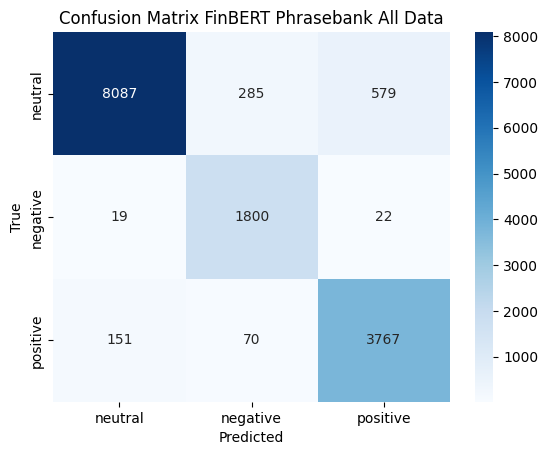

In [ ]:
# confusion matrix figure
import seaborn as sns
import matplotlib.pyplot as plt

labels = ['neutral', 'negative', 'positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix FinBERT Phrasebank All Data')
plt.show()

## Inference

### yfinance API feed news texts


In [ ]:
!pip install feedparser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.1 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=a0983612acb962ff66ec2dd70bce98f5efc1f56a9af58315d4fe2f215cab58f6
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [ ]:
import feedparser
import pandas as pd
ticker ="NVDA"
keyword ='nvda'

rss_url = f'https://finance.yahoo.com/rss/headline?s={ticker}'

feed = feedparser.parse(rss_url)

# feeds =[]
# for entry in feed.entries:
#   if keyword.lower() in entry.summary.lower():
#       feeds.append(entry)
# feed_df = pd.DataFrame(feeds)

feed_df = pd.DataFrame(feed.entries)
feed_df

,summary,summary_detail,id,guidislink,links,link,published,published_parsed,title,title_detail
0,The Dow Jones index rose Tuesday as the Fed's ...,"{'type': 'text/html', 'language': None, 'base'...",e3bee63a-ef41-31e3-af18-f582644f78ec,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://finance.yahoo.com/m/e3bee63a-ef41-31e3...,"Tue, 29 Jul 2025 13:48:42 +0000","(2025, 7, 29, 13, 48, 42, 1, 210, 0)",Stock Market Today: Dow Rises Amid Fed Meeting...,"{'type': 'text/plain', 'language': None, 'base..."
1,China demand spurs fresh TSMC chip deal,"{'type': 'text/html', 'language': None, 'base'...",364b4a00-acf0-388a-a492-9f671666533a,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://finance.yahoo.com/news/nvidia-doubles-...,"Tue, 29 Jul 2025 13:45:25 +0000","(2025, 7, 29, 13, 45, 25, 1, 210, 0)",Nvidia Doubles Down With Massive H20 Order,"{'type': 'text/plain', 'language': None, 'base..."
2,Nvidia's CEO has sold millions of dollars wort...,"{'type': 'text/html', 'language': None, 'base'...",763e3fab-3ae8-3a51-95a5-e6a0864e5ef6,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://www.fool.com/investing/2025/07/29/jens...,"Tue, 29 Jul 2025 13:23:00 +0000","(2025, 7, 29, 13, 23, 0, 1, 210, 0)",Jensen Huang Has Been Unloading Nvidia Stock T...,"{'type': 'text/plain', 'language': None, 'base..."
3,Ark Invest bought into some of its leaders and...,"{'type': 'text/html', 'language': None, 'base'...",b4b1f0af-301c-39e3-a09f-1ed914a9d852,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://www.fool.com/investing/2025/07/29/cath...,"Tue, 29 Jul 2025 13:15:00 +0000","(2025, 7, 29, 13, 15, 0, 1, 210, 0)",Cathie Wood Goes Shopping: 3 Stocks She Just B...,"{'type': 'text/plain', 'language': None, 'base..."
4,"NEW YORK, July 29, 2025--Torq, the autonomous ...","{'type': 'text/html', 'language': None, 'base'...",cab345fe-1658-33a5-9a44-b6ec4b2782ad,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://finance.yahoo.com/news/torq-amp-allian...,"Tue, 29 Jul 2025 13:00:00 +0000","(2025, 7, 29, 13, 0, 0, 1, 210, 0)","New Torq AMP Alliance Program Debuts with Wiz,...","{'type': 'text/plain', 'language': None, 'base..."
5,Nvidia Drives China Sales with Game?Changing 3...,"{'type': 'text/html', 'language': None, 'base'...",6aaf3d69-2791-3f6f-b4f0-7e1313e90185,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://finance.yahoo.com/news/nvidia-surges-a...,"Tue, 29 Jul 2025 12:32:31 +0000","(2025, 7, 29, 12, 32, 31, 1, 210, 0)","Nvidia Surges Ahead in China with 300,000 Chip...","{'type': 'text/plain', 'language': None, 'base..."
6,Investing.com -- ON Semiconductor (NASDAQ:ON) ...,"{'type': 'text/html', 'language': None, 'base'...",6b8ea549-2c1d-32a4-991d-9e8b32721e82,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://finance.yahoo.com/news/onsemi-stock-ri...,"Tue, 29 Jul 2025 12:24:22 +0000","(2025, 7, 29, 12, 24, 22, 1, 210, 0)",Onsemi stock rises on Nvidia collaboration for...,"{'type': 'text/plain', 'language': None, 'base..."
7,"AMD is surging, but is it overvalued? Explore ...","{'type': 'text/html', 'language': None, 'base'...",a48559e0-fe27-3089-98a6-d671e3cfa83b,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://www.barchart.com/story/news/33708841/2...,"Tue, 29 Jul 2025 12:13:50 +0000","(2025, 7, 29, 12, 13, 50, 1, 210, 0)",$200 AMD Price Target? Try These 2 Option Trad...,"{'type': 'text/plain', 'language': None, 'base..."
8,"SAN FRANCISCO (Reuters) -Enfabrica, a Silicon ...","{'type': 'text/html', 'language': None, 'base'...",da07fb09-eb89-369a-bd26-d0cd2afd61bc,False,"[{'rel': 'alternate', 'type': 'text/html', 'hr...",https://finance.yahoo.com/news/nvidia-backed-e...,"Tue, 29 Jul 2025 12:06:06 +0000","(2025, 7, 29, 12, 6, 6, 1, 210, 0)",Nvidia-backed Enfabrica releases system aimed ...,"{'type': 'text/plain', 'language': None, 'base..."
9,"News of the day for July 29, 2025","{'type': 'text/html', 'language': None, 'base'...",e38fca41-e2c

In [ ]:
feed_df['summary']

,summary
0,The Dow Jones index rose Tuesday as the Fed's ...
1,China demand spurs fresh TSMC chip deal
2,Nvidia's CEO has sold millions of dollars wort...
3,Ark Invest bought into some of its leaders and...
4,"NEW YORK, July 29, 2025--Torq, the autonomous ..."
5,Nvidia Drives China Sales with Game?Changing 3...
6,Investing.com -- ON Semiconductor (NASDAQ:ON) ...
7,"AMD is surging, but is it overvalued? Explore ..."
8,"SAN FRANCISCO (Reuters) -Enfabrica, a Silicon ..."
9,"News of the day for July 29, 2025"


### Inference

In [ ]:
texts = [
    "The company reported a 20% increase in revenue.",
    "Shares dropped after the disappointing forecast.",
    "Earnings per share were higher than expected.",
    "There was slight up and down in the prices.",
    "All stock market went up by 10%."
]

# texts = [
#     # Positive
#     "The company posted record profits this quarter.",
#     "Our revenue growth exceeded expectations by 15%.",

#     # Negative
#     "Shareholders were disappointed by the unexpected losses.",
#     "The CEO's resignation caused a drop in investor confidence.",

#     # Neutral
#     "The board meeting was held on Tuesday as planned.",
#     "The company released its annual report today.",

#     # Confusing/Ambiguous
#     "While revenue increased, net profit declined slightly.",
#     "Despite strong sales, the stock closed in the red.",
#     "Analysts are divided on the long-term outlook.",
#     "Not bad, but not great either — results were mixed.",
#     "The market responded unpredictably to the announcement.",
#     "It was an average quarter with no major surprises.",
# ]

texts = [
    # Ambiguous Positive
    "Though the company missed revenue expectations slightly, strong guidance for the next quarter helped restore investor optimism.",
    "Despite ongoing supply chain issues, management reaffirmed their long-term growth targets, which sent shares higher by close.",

    # Ambiguous Negative
    "Operating income fell short of estimates, even though net revenue remained stable, raising concerns about cost management.",
    "Although Q3 numbers improved marginally, analysts pointed out that the pace of recovery is slower than industry averages.",

    # Neutral but tricky
    "The firm announced a restructuring of its European operations, a move viewed by some as strategic and by others as reactive.",
    "Trading volume remained flat throughout the session despite a series of macroeconomic updates from the central bank.",

    # Mixed Sentiment
    "The acquisition is expected to be accretive to earnings, but integration challenges in key markets may weigh on short-term performance.",
    "While EPS beat forecasts, the drop in gross margin raised red flags among institutional investors.",

    # Subtle Negative
    "Executives avoided providing a clear answer regarding declining user engagement, which led to muted market reaction.",
    "Management emphasized their innovation pipeline, but deferred questions about recent layoffs and cost-cutting measures.",

    # Subtle Positive
    "Investor sentiment improved slightly after the CFO hinted at upcoming buybacks, though no official plan was confirmed.",
    "Even in the face of economic uncertainty, the company maintained its dividend payout and hinted at potential expansion."
]
#neutrals
# texts = [
#     "The quarterly earnings call is scheduled for next Monday at 10 AM.",
#     "The company appointed two new members to its board of directors.",
#     "Annual shareholder meeting materials were distributed to all registered investors.",
#     "The firm operates in over 25 countries with a focus on retail and manufacturing sectors.",
#     "The fiscal year ended on March 31, with audited results expected in the coming weeks.",
#     "Shares of the company traded within a narrow range during the session.",
#     "The dividend payout remains unchanged from the previous quarter.",
#     "The CFO presented an overview of the capital allocation strategy during the conference.",
#     "Trading volume was in line with the 30-day average.",
#     "The company announced a strategic partnership with a regional supplier.",
#     "Financial results were reported in accordance with IFRS standards.",
#     "The product launch timeline has been moved to Q4 to align with supply chain availability.",
#     "The firm completed a previously announced share repurchase program.",
#     "No material changes were made to the company's guidance for the upcoming quarter.",
#     "The restructuring plan will be implemented over the next six months with minimal disruption to operations."
# ]
#positive_texts
texts = [
    "Revenue surged to $5.2 billion this quarter, beating analyst expectations by a solid margin.",
    "EPS grew to $0.89, reflecting the company’s strong operational efficiency.",
    "Operating margin improved significantly, climbing to 42.5% thanks to cost discipline.",
    "Cash flow from operations hit $1.3 billion, highlighting robust financial health.",
    "The company maintained its dividend at $0.25 per share, reaffirming investor confidence.",
    "R&D spending rose to 12.3% of revenue, signaling continued commitment to innovation.",
    "Debt-to-equity remained healthy at 1.15, supporting a well-balanced capital structure.",
    "Return on equity stayed strong at 14.2%, outperforming industry benchmarks.",
    "The company completed its share repurchase program ahead of schedule, boosting shareholder value.",
    "Management raised full-year guidance, citing strong customer demand and favorable market trends."
]
#neutral_texts
texts_only = [
    "Revenue was reported at $5.2 billion, compared to $5.1 billion in the prior quarter.",
    "EPS came in at $0.89, in line with the same period last year.",
    "Operating margin stood at 42.5%, unchanged from the previous quarter.",
    "Cash flow from operations totaled $1.3 billion, consistent with recent quarters.",
    "The dividend was maintained at $0.25 per share.",
    "R&D expenses represented 12.3% of total revenue.",
    "The debt-to-equity ratio was 1.15, flat quarter-over-quarter.",
    "Return on equity remained steady at 14.2%.",
    "The share repurchase program was completed as previously planned.",
    "Guidance for the remainder of the year remains unchanged."
]
#negative_texts
texts = [
    "Revenue only reached $5.2 billion, falling short of bullish market forecasts.",
    "EPS stagnated at $0.89, showing limited improvement year-over-year.",
    "Operating margin failed to expand, remaining flat at 42.5%.",
    "Cash flow from operations slipped slightly to $1.3 billion, raising concerns over liquidity.",
    "Dividend was not increased, potentially disappointing income-focused investors.",
    "R&D spending rose to 12.3%, putting pressure on short-term profitability.",
    "Debt-to-equity stayed elevated at 1.15, suggesting ongoing leverage concerns.",
    "Return on equity held at 14.2%, lagging behind aggressive competitors.",
    "Share repurchase efforts had limited impact on stock performance.",
    "Management opted not to revise guidance, citing ongoing uncertainty in core markets."
]
#tweets
texts_only = [
    # Positive
    "Earnings smashed expectations 💥 $AAPL posts $0.89 EPS vs $0.78 est. Bullish momentum incoming! 📈 #EarningsSeason",
    "$TSLA revenue up 25% YoY and margins holding strong. The growth story continues. 🚀 #Tesla #Markets",
    "Great call from $MSFT today — solid numbers and confident guidance. Holding long. 🧠📊 #Microsoft #Investing",
    "$NVDA crushed it again. Insane demand for AI chips driving record profits. #semiconductors #NVDA",
    "$AMZN just announced a $10B buyback. That’s a huge vote of confidence from management! 🔥 #stocks",

    # Neutral
    "$GOOG reports Q2 results: EPS $1.45, revenue $74.6B. In line with expectations. #Alphabet",
    "Federal Reserve to hold rates steady at 5.25%. Statement mostly unchanged from last month. #FOMC",
    "$WMT declared a $0.56 quarterly dividend. Ex-div date: Aug 10. #dividends #Walmart",
    "Markets opened flat as investors digest mixed earnings. Volume remains light. #SP500",
    "The ECB released its economic outlook. Forecasts remain largely consistent with previous projections. #eurozone",

    # Negative
    "$META down 8% after missing on ad revenue. Growth slowing in key regions. Ouch. 😬📉 #Meta #FAANG",
    "Disappointing numbers from $NFLX — subscriber growth stalls again. Bear case gaining steam. 🐻 #Netflix",
    "Ugly earnings from $INTC. Margins crushed, weak outlook. No bottom yet in sight. #Intel #TechStocks",
    "$UBER under SEC investigation over disclosure practices. Stock drops 5% on the news. 🚨 #Uber #Finance",
    "Massive layoffs coming at $GOOG according to internal sources. Company confirms 'restructuring'. 😕 #Google #TechLayoffs",

    # Ambiguous / Mixed
    "Well, $AMZN beat earnings... but the stock still tanked 4%. Market logic 🤷‍♂️ #investing",
    "$TSLA growth is slowing — but hey, at least Elon tweeted something funny today. #Tesla #markets",
    "EPS beat but revenue missed. Forecast cut, but CEO sounded confident? Mixed signals. #SP500",
    "No dividend hike again from $KO. Conservative or just boring? You decide. #CocaCola"
]
#news_headlines
texts = [
    # Positive
    "Apple Beats Q2 Expectations With Record iPhone Sales",
    "Tesla Stock Soars as EV Deliveries Surpass Forecasts",
    "Microsoft Raises Guidance After Cloud Revenue Jump",
    "NVIDIA Posts Record Profits on AI Chip Demand Surge",
    "Amazon Announces $20B Share Buyback Amid Strong Growth",

    # Neutral
    "Federal Reserve Holds Interest Rates Steady at 5.25%",
    "Alphabet Reports Q2 Results in Line With Analyst Estimates",
    "Meta Reorganizes Business Units Ahead of Product Launches",
    "Global Oil Prices Remain Stable Amid OPEC Output Decisions",
    "Walmart Maintains Dividend Despite Flat Quarterly Revenue",

    # Negative
    "Netflix Shares Slide After Subscriber Growth Miss",
    "Intel Warns of Soft Demand in PC Market, Cuts Outlook",
    "JP Morgan Hit With $250M Fine Over Compliance Failures",
    "Boeing Faces Delays in Jet Deliveries Due to Supply Chain Issues",
    "Google Parent Alphabet to Lay Off 12,000 Employees in Restructuring",

    # Ambiguous / Mixed
    "Goldman Sachs Beats EPS Estimates but Trading Revenue Falls",
    "Pfizer Reports Decline in Vaccine Sales, Boosts R&D Spending",
    "Salesforce Sees Slower Growth Ahead Despite Strong Quarter",
    "Ford Posts Strong EV Sales, Warns of Margin Pressure",
    "Amazon Misses on Revenue But Sees Optimism in Holiday Outlook"
]
#out_of_context_news
texts = [
    "Scientists Discover New Species of Glow-in-the-Dark Frog in Amazon Rainforest",
    "Local Cat Elected Mayor of Small Town in Viral Social Media Sensation",
    "Researchers Develop Edible Water Bottles to Reduce Plastic Waste",
    "Ancient Roman Sword Found During Subway Construction in London",
    "World’s Largest Chocolate Sculpture Unveiled at City Festival",
    "Mystery Crop Circles Appear Overnight in Rural Midwest",
    "Astronauts Celebrate Birthday With Zero-Gravity Cake in Space Station",
    "Unexpected Snowstorm Hits Sahara Desert, Blanketing Sand Dunes",
    "Virtual Reality Therapy Shows Promise for Treating PTSD Patients",
    "Lost Hiker Rescued After 10 Days Using Only Smartphone GPS",
    "New App Translates Dog Barks Into Human Language",
    "Artists Create Stunning Mural Using Recycled Electronics Components",
    "Oldest Known Message in a Bottle Found on Australian Beach",
    "Drone Delivers Medical Supplies to Remote Mountain Village",
    "City Bans Use of Plastic Straws to Protect Marine Life",
]

# finbert failed texts
texts_only = [
    "Pre-tax loss totaled euro 0.3 million ,compared to a loss of euro 2.2 million in the first quarter of 2005 .",
    "This implementation is very important to the operator , since it is about to launch its Fixed to Mobile convergence service in Brazil",
    "The situation of coated magazine printing paper will continue to be weak ."
]

# mathematical comparison
texts = [
    "Net profit to euro 103 million from euro 172 million in the previous year.",
    "Net profit to euro 203 million from euro 172 million in the previous year.",
    "Pre-tax loss totaled euro 0.3 million , compared to a loss of euro 2.2 million in the first quarter of 2005 .",
    "Pre-tax loss totaled euro 5.3 million , compared to a loss of euro 2.2 million in the first quarter of 2005 .",
    "Net profit totaled euro 5.3 million , compared to euro 2.2 million in the previous quarter of 2005 .",
    "Net profit totaled euro 0.3 million , compared to euro 2.2 million in the previous quarter of 2005 .",
]

texts = texts_only

label_map = {0: "positive", 1: "negative", 2: "neutral"}
label_map_ours = {0: "neutral", 1: "negative", 2: "positive"}



def get_predictions_and_probs(model, inputs, label_map):
    """
    Predict labels and probabilities from a model given inputs and label_map.

    Args:
        model (torch.nn.Module): Trained model.
        inputs (dict): Tokenized inputs (from tokenizer(..., return_tensors='pt')).
        label_map (dict): Mapping from class indices to label names.

    Returns:
        predicted_labels (List[str]): List of predicted label names.
        probs (List[float]): List of maximum softmax probabilities.
    """
    # model.eval()  # set model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        softmax_probs = torch.nn.functional.softmax(logits, dim=-1)

        max_probs, predictions = torch.max(softmax_probs, dim=-1)
        predicted_labels = [label_map[idx.item()] for idx in predictions]
        probs = max_probs.tolist()

    return predicted_labels, probs

# Tokenize inputs
# inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
inputs_ours = tokenizer_ours(texts, padding=True, truncation=True, return_tensors="pt").to(device)
# inputs_ours_math = tokenizer_ours_math(texts, padding=True, truncation=True, return_tensors="pt").to(device)
# inputs_ours_math_only = tokenizer_ours_math_only(texts, padding=True, truncation=True, return_tensors="pt").to(device)

# Output
# finbert_predicted_labels, finbert_probs = get_predictions_and_probs(model, inputs, label_map)
ours_predicted_labels, ours_probs = get_predictions_and_probs(model_ours, inputs_ours, label_map_ours)
# ours_math_predicted_labels, ours_math_probs = get_predictions_and_probs(model_ours_math, inputs_ours_math, label_map_ours)
# ours_math_only_predicted_labels, ours_math_only_probs = get_predictions_and_probs(model_ours_math_only, inputs_ours_math_only, label_map_ours)

results_df = pd.DataFrame({
    "Text": texts,
    # "FinBERT": finbert_predicted_labels,
    # "FinBERT_prob": finbert_probs,
    "Ours": ours_predicted_labels,
    "Ours_prob": ours_probs,
    # "Ours_math": ours_math_predicted_labels,
    # "Ours_math_prob": ours_math_probs,
    # "Ours_math_only": ours_math_only_predicted_labels,
    # "Ours_math_only_prob": ours_math_only_probs
})

results_df


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,Text,Ours,Ours_prob
0,"Pre-tax loss totaled euro 0.3 million ,compare...",positive,0.999718
1,This implementation is very important to the o...,neutral,0.999769
2,The situation of coated magazine printing pape...,negative,0.999628


### SHAP Analysis

In [ ]:
import matplotlib.pyplot as plt

def plot_shap_values_own_class(text,values, class_index,tokens,predicted_label,probab_score,top_n=10):

  values = values[:, class_index]
  # === Sort tokens by absolute contribution ===
  sorted_pairs = sorted(zip(tokens, values), key=lambda x: abs(x[1]), reverse=True)[:top_n]
  sorted_tokens, sorted_values = zip(*sorted_pairs)

  # === Plot Bar Chart ===
  plt.figure(figsize=(10, 5))
  bar_colors = ['green' if val > 0 else 'red' for val in sorted_values]
  plt.barh(sorted_tokens, sorted_values, color=bar_colors)
  plt.xlabel(f"SHAP Value (Impact on Sentiment Prediction) on {predicted_label} class")
  plt.title(f"Top {top_n} Token Contributions per Sentiment Class\nLabel: {predicted_label}\nScore: {probab_score} \n Text: {text} ", fontsize=10)
  plt.gca().invert_yaxis()  # Highest at top
  plt.tight_layout()
  plt.show()

def plot_shap_values_each_class(text,values, class_index,tokens,predicted_label,probab_score,top_n=10):
  fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
  fig.suptitle(f"Top {top_n} Token Contributions per Sentiment Class\nLabel: {predicted_label}\nScore: {probab_score} \n Text: {text} ", fontsize=10)


  for class_index, ax in enumerate(axes):
      class_values = values[:, class_index]
      label = label_map_ours[class_index]

      # Sort tokens by abs value
      sorted_pairs = sorted(zip(tokens, class_values), key=lambda x: abs(x[1]), reverse=True)[:top_n]
      sorted_tokens, sorted_values = zip(*sorted_pairs)

      bar_colors = ['green' if val > 0 else 'red' for val in sorted_values]
      ax.barh(sorted_tokens, sorted_values, color=bar_colors)
      ax.set_title(f"{label.capitalize()} Class")
      ax.set_xlabel("SHAP Value")
      ax.invert_yaxis()

  plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for suptitle

  # plt.savefig("shap_token_contributions_all_classes.png", dpi=300)
  plt.show()

Device set to use cpu


📰 News: Pre-tax loss totaled euro 5.3 million , compared to a loss loss of euro 2.2 million in the first quarter of 2005 .
🔍 Predicted sentiment: positive 0.9997304081916809


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:33, 93.85s/it]               


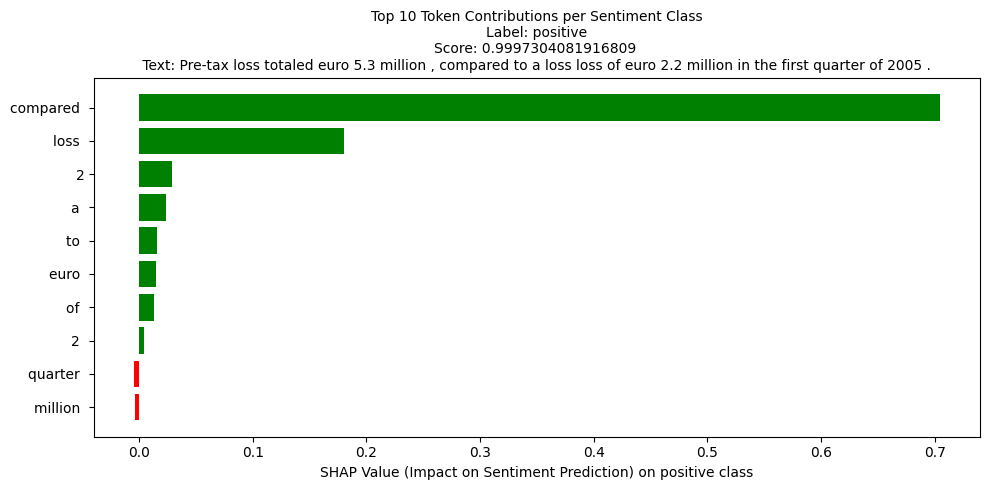

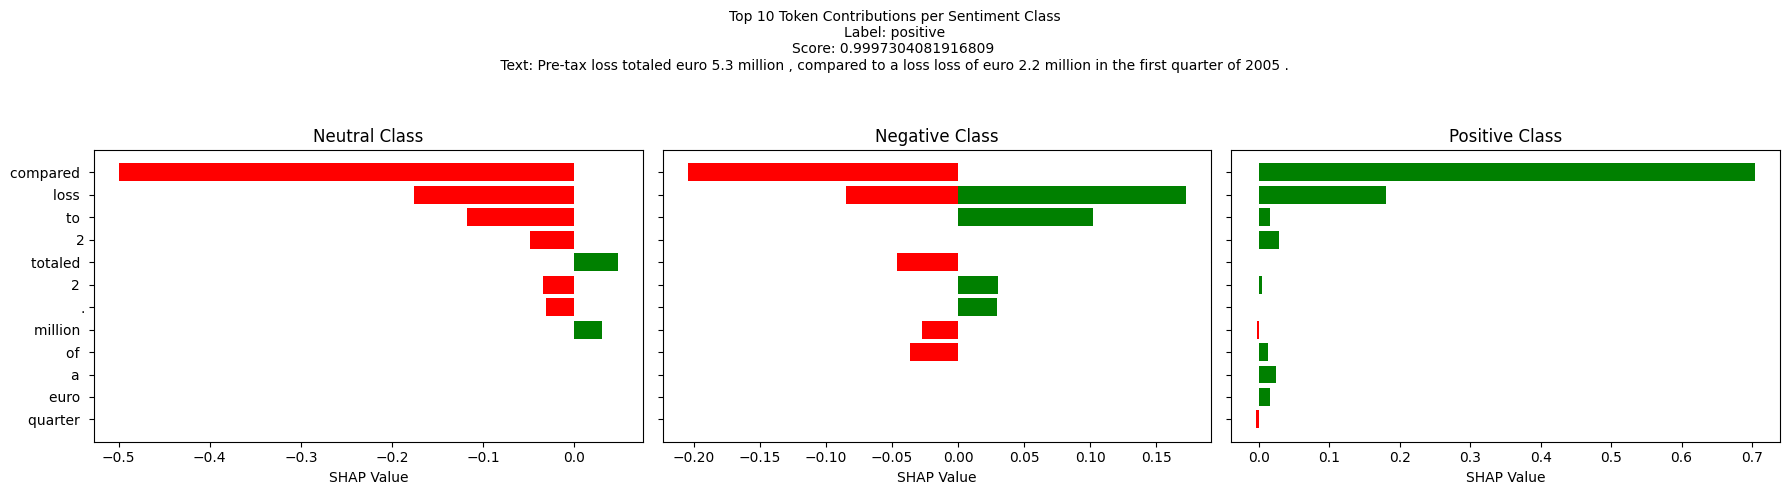

In [ ]:
import shap
import torch
import numpy as np
from transformers import pipeline


label_map_ours = {0: "neutral", 1: "negative", 2: "positive"}

# === News texts ===
text = "Pre-tax loss totaled euro 5.3 million , compared to a loss of euro 2.2 million in the first quarter of 2005 ."

# text = "Pre-tax loss totaled euro 0.3 million ,compared to a loss of euro 2.2 million in the first quarter of 2005 ."
# text = "This implementation is very important to the operator , since it is about to launch its Fixed to Mobile convergence service in Brazil"
# text = "The situation of coated magazine printing paper will continue to be weak ."

# === Wrap your model in a pipeline ===
pipe = pipeline("text-classification", model=model_ours, tokenizer=tokenizer_ours, return_all_scores=True, device=0 if torch.cuda.is_available() else -1)

# === Function to predict label only ===
def predict_label(text):
    scores = pipe(text)[0]
    pred_index = np.argmax([s["score"] for s in scores])
    # get the score as well
    pred_score = scores[pred_index]["score"]
    return label_map_ours[pred_index],pred_score,pred_index


def do_shap_analysis(text,pipe,predicted_label, probab_score,class_index):

  # === Use SHAP for explanation ===
  explainer = shap.Explainer(pipe)
  shap_values = explainer([text])

  # === Visualize the explanation ===
  # shap.plots.text(shap_values[0])

  # === Extract SHAP values for bar chart ===
  shap_text = shap_values[0]
  tokens = shap_text.data
  # values = shap_text.values[:,class_index]
  values = shap_text.values # shape: (num_tokens, num_classes)
  top_n = 10  # Number of top tokens to plot per class


  # plot shap tokens bar chart
  plot_shap_values_own_class(text,values, class_index,tokens,predicted_label,probab_score,top_n)
  plot_shap_values_each_class(text,values, class_index,tokens,predicted_label,probab_score,top_n)


predicted_label, probab_score,class_index = predict_label(text)

print("📰 News:", text)
print("🔍 Predicted sentiment:", predicted_label, probab_score)

do_shap_analysis(text,pipe,predicted_label, probab_score,class_index)



# Hugging Face Deployment

In [ ]:
from huggingface_hub import login
login(token="hf_xxxxxxxxxxxxx") # push hugging face token

In [ ]:
from huggingface_hub import HfApi
import os

api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="/content/finbert-finetuned", 
    repo_id="user-name/finbert-finetune",
    repo_type="model",
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/project-aps/finbert-finetune/commit/97b70bdbdba128d0e7c426e187754a04ae2afc9b', commit_message='Upload folder using huggingface_hub', commit_description='', oid='97b70bdbdba128d0e7c426e187754a04ae2afc9b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/project-aps/finbert-finetune', endpoint='https://huggingface.co', repo_type='model', repo_id='project-aps/finbert-finetune'), pr_revision=None, pr_num=None)

# Hugging Face Inference

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch


In [ ]:
model_name = "project-aps/finbert-finetune"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)



In [ ]:
# using pipeline
# Override the config's id2label and label2id
label_map = {0: "neutral", 1: "negative", 2: "positive"}
model.config.id2label = label_map
model.config.label2id = {v: k for k, v in label_map.items()}

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)



In [ ]:
text = "Earnings smashed expectations AAPL posts $0.89 EPS vs $0.78 est. Bullish momentum incoming! #EarningsSeason"
print(pipe(text)) #Output: [{'label': 'positive', 'score': 0.9997484087944031}]
